## Simple Notebook for preparing the whole training run in one graph

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
import re
%matplotlib inline

In [2]:
plt.style.use('seaborn-notebook')
export_plots = False #True

### Load the exported data from the Keras Run

In [3]:
# load the json file
with open('lr_0.1_keras/logs/train_history.json') as json_data:
    metric_data_keras = json.load(json_data)

## Create a list of integer to string converted values which is used for mapping the our k_step to our value

In [4]:
# create history object which stores all training metrics for this
hist_lr_0_1_keras = {}

k_step_keys = [str(i) for i in list(range(len(metric_data_keras['loss'])))]


for key in metric_data_keras.keys():
    hist_lr_0_1_keras[key] = [metric_data_keras[key][cur_k_step] for cur_k_step in k_step_keys]

### Load the exported metrics from the MXNET Run exported Tensorboard

In [3]:
def get_hist_metrics(lr='0.01'):
    """
    Loads the exported metrics from .json files in a dictionary obj. with 2D numpy arrays
    """
    json_files = glob.glob('./lr_%s_mxnet/logs/json/*' % lr)
    hist_metrics = {}
    for json_file in json_files:
        
        # extract the metric name using a regular expression
        m = re.search(r'(?<=run_.-tag-)\w+(?<!.json)', json_file)
        metric_name = m.group(0)
        
        # load the one json file of which each contain a metric
        with open(json_file) as json_data:
            data = json.load(json_data)

        # store the metric data in a 2D-numpy array
        metric_data = np.zeros((len(data), 2))
        for i, row in enumerate(data):
            metric_data[i, :] = row[1], row[2]

        # fill in our dict object using the stored values
        hist_metrics[metric_name] = metric_data
        
    return hist_metrics

In [6]:
hist_lr_0_01_mxnet = get_hist_metrics(lr='0.01')
hist_lr_0_001_mxnet = get_hist_metrics(lr='0.001')

In [7]:
total_k_steps = int(hist_lr_0_001_mxnet['train_policy_loss'][-1, 0])+1


In [8]:
metrics_compact = {}

try:
    plt.plot(hist_lr_0_1_keras[metric])
except KeyError:
    plt.plot(hist_lr_0_1_keras[metric.replace('train_', '')])

metric = np.zeros(total_k_steps)

In [9]:
metrics_compact

{}

In [10]:
metrics_compact = {}

for hist in [hist_lr_0_01_mxnet, hist_lr_0_001_mxnet]:
    for metric in hist.keys():
        for type_metric in ['train_', 'val_']:
            if type_metric in metric:
                metric_crop = metric.replace(type_metric, '')
                if metric_crop not in metrics_compact:
                    metrics_compact[metric_crop] = {}
                if type_metric not in metrics_compact[metric_crop]:
                    metrics_compact[metric_crop][type_metric] = np.zeros(total_k_steps)
                #print(metrics_compact)
                for row in hist[metric]:
                    #print(row[0])
                    (metrics_compact[metric_crop][type_metric])[int(row[0])] = row[1]

## Fill in the first values

In [11]:
hist_lr_0_1_keras.keys()

dict_keys(['loss', 'policy_acc', 'policy_acc_sign', 'policy_loss', 'val_loss', 'val_policy_acc', 'val_policy_acc_sign', 'val_policy_loss', 'val_value_acc', 'val_value_acc_sign', 'val_value_loss', 'value_acc', 'value_acc_sign', 'value_loss'])

In [12]:
for metric in hist_lr_0_1_keras:
    if 'val_' in metric:
        for i, val in enumerate(hist_lr_0_1_keras[metric]):
            metric_crop = metric.replace('val_', '')
            if metric_crop in metrics_compact:
                if metrics_compact[metric_crop]['val_'][i] == 0:
                    metrics_compact[metric_crop]['val_'][i] = val
    else:  # train metric
        for i, val in enumerate(hist_lr_0_1_keras[metric]):
            if metric in metrics_compact:
                if metrics_compact[metric]['train_'][i] == 0:
                    metrics_compact[metric]['train_'][i] = val        

## Now visualisize the full data

In [13]:
def apply_def(filename):
    plt.legend()
    plt.grid(axis='y')
    plt.xlabel('Thousands of Steps / Batch-Size 2048')
    if export_plots is True:
        plt.savefig('./plots/%s.png'%filename)
        plt.savefig('./plots/%s.pdf'%filename)
    plt.show()

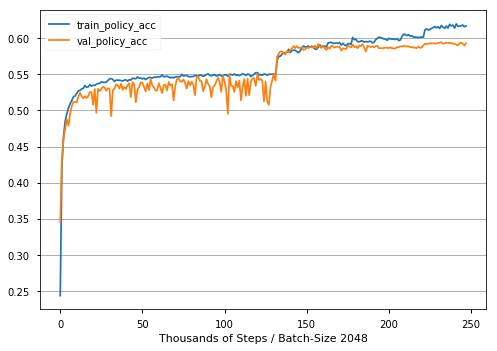

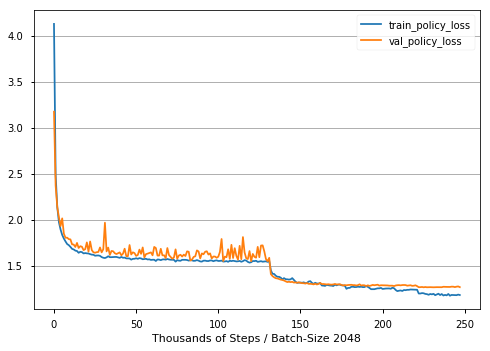

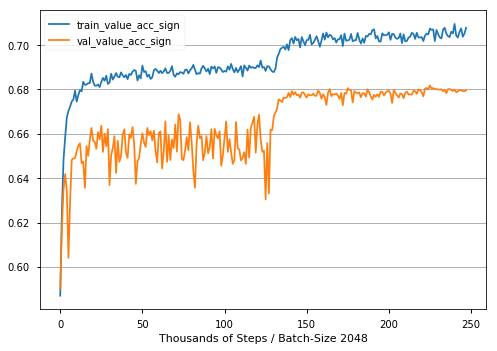

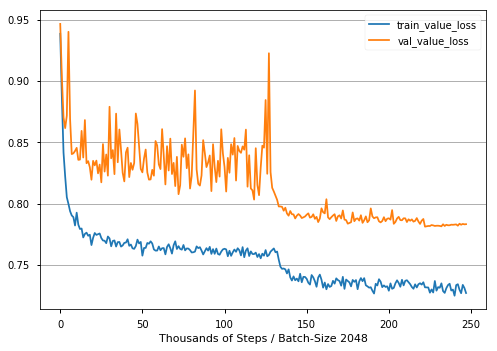

In [14]:
for metric in metrics_compact:
    for type_set in metrics_compact[metric]:
        plt.plot(metrics_compact[metric][type_set][:-3], label='%s%s'%(type_set, metric)) # [:-3] because the last 3 entries are 0 somehow
    apply_def(metric)

## Export the structure of the network architecture

In [15]:
import sys
sys.path.insert(0,'../../../../../')

In [16]:
from DeepCrazyhouse.src.training.architecture.mxnet_alpha_zero import alpha_zero_model

ModuleNotFoundError: No module named 'DeepCrazyhouse.src.training.architecture'

In [21]:
import mxnet as mx

In [ ]:
# get the symbol defintion of the alpha zero architecture
sym = alpha_zero_model(num_res_blocks=7, n_labels=4992, grad_scale_value=0.01, grad_scale_policy=0.99)
# Visualize your network
pltn = mx.viz.plot_network(sym)
pltn.view('./plots/alpha_zero_model_7x256')

In [20]:
from DeepCrazyhouse.configs.main_config import main_config
from glob import glob

In [19]:
sym_path = glob(main_config['model_architecture_dir'] + '*')[0]
sym_path

NameError: name 'main_config' is not defined

### Export the full architecture graph for RISE

In [18]:
sym = mx.sym.load(sym_path)

input_shape = (34, 8, 8)

plot_fig = mx.viz.plot_network(sym, shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])}, node_attrs={"fixedsize":"false"} )
plot_fig

NameError: name 'sym_path' is not defined

In [ ]:
plot_fig.view('./1_cycle_rise/plots/rise_7x12')

In [22]:
# load the json file
with open('1_cycle_rise/json/run_.-tag-lr.json') as json_data:
    lr_data = json.load(json_data)

In [23]:
lr_data_raw = []
for item in lr_data:
    lr_data_raw.append(item[2])

In [24]:
with open('1_cycle_rise/json/run_.-tag-momentum.json') as json_data:
    momentum_data = json.load(json_data)

In [25]:
momentum_data_raw = []
for item in momentum_data:
    momentum_data_raw.append(item[2])

In [26]:
def get_raw_data(json_data):
    data_raw = []
    for item in json_data:
        data_raw.append(item[2])
    return data_raw

### Definition of the individual settings for the training runs

In [4]:
batch_size_crazyara_01 = 2048
batch_size_crazyara_02 = 1024

x_crazyara_01 = np.arange(0, len(metrics_compact['policy_loss']['val_'])) * batch_size_crazyara_01 * 1000
x_crazyara_02_init_run = np.arange(0, len(lr_data_raw)) * batch_size_crazyara_02 * 1000

NameError: name 'metrics_compact' is not defined

In [5]:
export_plots = True

In [7]:
def apply_def(filename):
    plt.legend(frameon=True)
    plt.grid(axis='x')
    plt.xlabel('Number of Training Samples processed')
    if export_plots is True:
        plt.savefig('./plots/report/%s.png'%filename, bbox='tight')
        plt.savefig('./plots/report/%s.pdf'%filename, bbox='tight')
    plt.show()

### Learning Rate Schedule

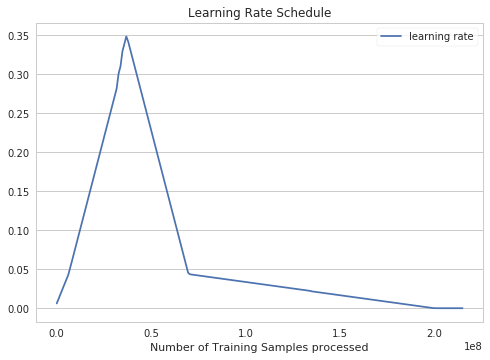

In [49]:
plt.plot(x_crazyara_02_init_run, lr_data_raw[:len(x_crazyara_02)], label='learning rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Number of Training Samples processed')
apply_def('lr_schedule')

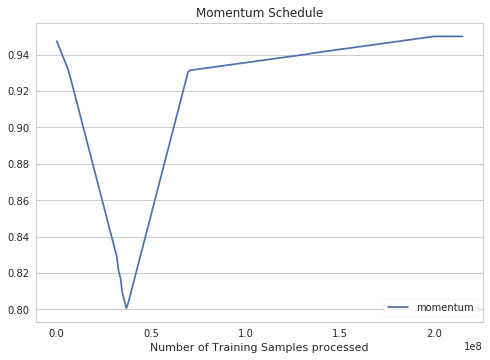

In [50]:
plt.plot(x_crazyara_02_init_run, momentum_data_raw[:len(x_crazyara_02)], label='momentum')
plt.title('Momentum Schedule')
apply_def('momentum_schedule')

### Policy Loss

In [12]:
with open('./report/4_value_ch_8_policy_ch/run_policy_loss_val-tag-policy_loss.json') as json_data:
    val_policy_loss = json.load(json_data)
    val_policy_loss = get_raw_data(val_policy_loss)

FileNotFoundError: [Errno 2] No such file or directory: './report/4_value_ch_8_policy_ch/run_policy_loss_val-tag-policy_loss.json'

In [51]:
with open('1_cycle_rise/json/run_policy_loss_val-tag-policy_loss.json') as json_data:
    val_policy_loss = json.load(json_data)
    val_policy_loss = get_raw_data(val_policy_loss)
with open('1_cycle_rise/final_cooldown_1/json/run_policy_loss_val-tag-policy_loss.json') as json_data:
    val_policy_loss_cd1 = json.load(json_data)
    val_policy_loss_cd1 = get_raw_data(val_policy_loss_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_policy_loss_val-tag-policy_loss.json') as json_data:
    val_policy_loss_cd2 = json.load(json_data)
    val_policy_loss_cd2 = get_raw_data(val_policy_loss_cd2)  
val_policy_loss_total = val_policy_loss + val_policy_loss_cd1 + val_policy_loss_cd2

In [52]:
with open('1_cycle_rise/json/run_policy_loss_train-tag-policy_loss.json') as json_data:
    train_policy_loss = json.load(json_data)
    train_policy_loss = get_raw_data(train_policy_loss)
with open('1_cycle_rise/final_cooldown_1/json/run_policy_loss_train-tag-policy_loss.json') as json_data:
    train_policy_loss_cd1 = json.load(json_data)
    train_policy_loss_cd1 = get_raw_data(train_policy_loss_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_policy_loss_train-tag-policy_loss.json') as json_data:
    train_policy_loss_cd2 = json.load(json_data)
    train_policy_loss_cd2 = get_raw_data(train_policy_loss_cd2)  
train_policy_loss_total = train_policy_loss + train_policy_loss_cd1 + train_policy_loss_cd2

### Policy Accuracy

In [53]:
with open('1_cycle_rise/json/run_policy_acc_val-tag-policy_acc.json') as json_data:
    val_policy_acc = json.load(json_data)
    val_policy_acc = get_raw_data(val_policy_acc)
with open('1_cycle_rise/final_cooldown_1/json/run_policy_acc_val-tag-policy_acc.json') as json_data:
    val_policy_acc_cd1 = json.load(json_data)
    val_policy_acc_cd1 = get_raw_data(val_policy_acc_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_policy_acc_val-tag-policy_acc.json') as json_data:
    val_policy_acc_cd2 = json.load(json_data)
    val_policy_acc_cd2 = get_raw_data(val_policy_acc_cd2)  
val_policy_acc_total = val_policy_acc + val_policy_acc_cd1 + val_policy_acc_cd2


In [54]:
with open('1_cycle_rise/json/run_policy_acc_train-tag-policy_acc.json') as json_data:
    train_policy_acc = json.load(json_data)
    train_policy_acc = get_raw_data(train_policy_acc)
with open('1_cycle_rise/final_cooldown_1/json/run_policy_acc_train-tag-policy_acc.json') as json_data:
    train_policy_acc_cd1 = json.load(json_data)
    train_policy_acc_cd1 = get_raw_data(train_policy_acc_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_policy_acc_train-tag-policy_acc.json') as json_data:
    train_policy_acc_cd2 = json.load(json_data)
    train_policy_acc_cd2 = get_raw_data(train_policy_acc_cd2)  
train_policy_acc_total = train_policy_acc + train_policy_acc_cd1 + train_policy_acc_cd2

### Value Loss

In [55]:
with open('1_cycle_rise/json/run_value_loss_val-tag-value_loss.json') as json_data:
    val_value_loss = json.load(json_data)
    val_value_loss = get_raw_data(val_value_loss)
with open('1_cycle_rise/final_cooldown_1/json/run_value_loss_val-tag-value_loss.json') as json_data:
    val_value_loss_cd1 = json.load(json_data)
    val_value_loss_cd1 = get_raw_data(val_value_loss_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_value_loss_val-tag-value_loss.json') as json_data:
    val_value_loss_cd2 = json.load(json_data)
    val_value_loss_cd2 = get_raw_data(val_value_loss_cd2)  
val_value_loss_total = val_value_loss + val_value_loss_cd1 + val_value_loss_cd2

In [56]:
with open('1_cycle_rise/json/run_value_loss_train-tag-value_loss.json') as json_data:
    train_value_loss = json.load(json_data)
    train_value_loss = get_raw_data(train_value_loss)
with open('1_cycle_rise/final_cooldown_1/json/run_value_loss_train-tag-value_loss.json') as json_data:
    train_value_loss_cd1 = json.load(json_data)
    train_value_loss_cd1 = get_raw_data(train_value_loss_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_value_loss_train-tag-value_loss.json') as json_data:
    train_value_loss_cd2 = json.load(json_data)
    train_value_loss_cd2 = get_raw_data(train_value_loss_cd2)  
train_value_loss_total = train_value_loss + train_value_loss_cd1 + train_value_loss_cd2

### Value Acc Sign

In [57]:
with open('1_cycle_rise/json/run_value_acc_sign_train-tag-value_acc_sign.json') as json_data:
    train_value_acc_sign = json.load(json_data)
    train_value_acc_sign = get_raw_data(train_value_acc_sign)
with open('1_cycle_rise/final_cooldown_1/json/run_value_acc_sign_train-tag-value_acc_sign.json') as json_data:
    train_value_acc_sign_cd1 = json.load(json_data)
    train_value_acc_sign_cd1 = get_raw_data(train_value_acc_sign_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_value_acc_sign_train-tag-value_acc_sign.json') as json_data:
    train_value_acc_sign_cd2 = json.load(json_data)
    train_value_acc_sign_cd2 = get_raw_data(train_value_acc_sign_cd2)  
train_value_acc_sign_total = train_value_acc_sign + train_value_acc_sign_cd1 + train_value_acc_sign_cd2

In [58]:
with open('1_cycle_rise/json/run_value_acc_sign_val-tag-value_acc_sign.json') as json_data:
    val_value_acc_sign = json.load(json_data)
    val_value_acc_sign = get_raw_data(val_value_acc_sign)
with open('1_cycle_rise/final_cooldown_1/json/run_value_acc_sign_val-tag-value_acc_sign.json') as json_data:
    val_value_acc_sign_cd1 = json.load(json_data)
    val_value_acc_sign_cd1 = get_raw_data(val_value_acc_sign_cd1)    
with open('1_cycle_rise/final_cooldown_2/json/run_value_acc_sign_val-tag-value_acc_sign.json') as json_data:
    val_value_acc_sign_cd2 = json.load(json_data)
    val_value_acc_sign_cd2 = get_raw_data(val_value_acc_sign_cd2)  
val_value_acc_sign_total = val_value_acc_sign + val_value_acc_sign_cd1 + val_value_acc_sign_cd2

In [59]:
import seaborn as sns;
sns.set()
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind")

In [62]:
x_crazyara_02 = np.arange(0, len(val_policy_loss_total)) * batch_size_crazyara_02 * 1000

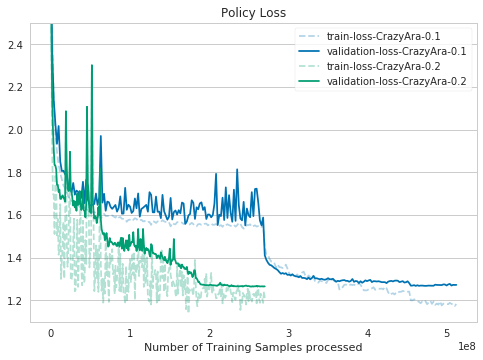

In [63]:
plt.plot(x_crazyara_01, metrics_compact['policy_loss']['train_'], '--', c=colors[0], alpha=0.3, label='train-loss-CrazyAra-0.1')
plt.plot(x_crazyara_01, metrics_compact['policy_loss']['val_'],  c=colors[0], label='validation-loss-CrazyAra-0.1')
plt.plot(x_crazyara_02, train_policy_loss_total, '--', c=colors[1], alpha=0.3, label='train-loss-CrazyAra-0.2')
plt.plot(x_crazyara_02, val_policy_loss_total, c=colors[1],  label='validation-loss-CrazyAra-0.2')
plt.title('Policy Loss')
plt.ylim([1.1,2.5])
apply_def('policy_loss')

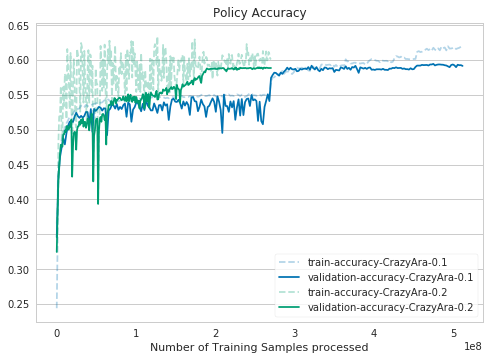

In [67]:
plt.plot(x_crazyara_01, metrics_compact['policy_acc']['train_'], '--', c=colors[0], alpha=0.3, label='train-accuracy-CrazyAra-0.1')
plt.plot(x_crazyara_01, metrics_compact['policy_acc']['val_'],  c=colors[0], label='validation-accuracy-CrazyAra-0.1')
plt.plot(x_crazyara_02, train_policy_acc_total, '--', c=colors[1], alpha=0.3, label='train-accuracy-CrazyAra-0.2')
plt.plot(x_crazyara_02, val_policy_acc_total, c=colors[1],  label='validation-accuracy-CrazyAra-0.2')
plt.title('Policy Accuracy')
apply_def('policy_acc')

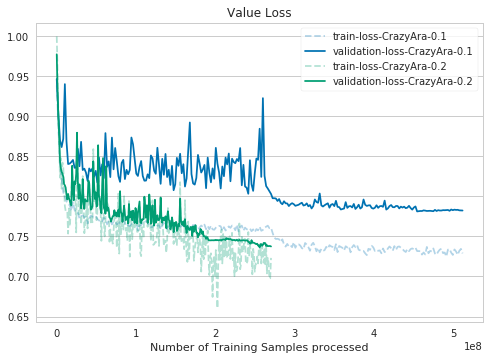

In [68]:
plt.plot(x_crazyara_01, metrics_compact['value_loss']['train_'], '--', c=colors[0], alpha=0.3, label='train-loss-CrazyAra-0.1')
plt.plot(x_crazyara_01, metrics_compact['value_loss']['val_'],  c=colors[0], label='validation-loss-CrazyAra-0.1')
plt.plot(x_crazyara_02, train_value_loss_total, '--', c=colors[1], alpha=0.3, label='train-loss-CrazyAra-0.2')
plt.plot(x_crazyara_02, val_value_loss_total, c=colors[1], label='validation-loss-CrazyAra-0.2')
plt.title('Value Loss')
apply_def('value_loss')

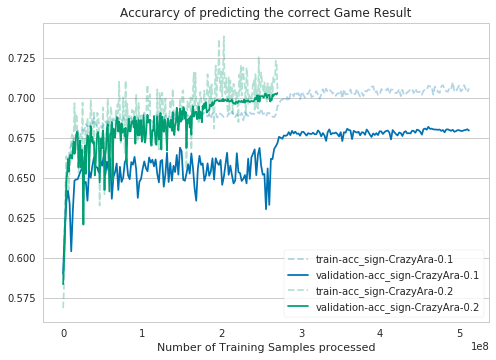

In [73]:
plt.plot(x_crazyara_01, metrics_compact['value_acc_sign']['train_'], '--', c=colors[0], alpha=0.3, label='train-acc_sign-CrazyAra-0.1')
plt.plot(x_crazyara_01, metrics_compact['value_acc_sign']['val_'],  c=colors[0], label='validation-acc_sign-CrazyAra-0.1')
plt.plot(x_crazyara_02, train_value_acc_sign_total, '--', c=colors[1], alpha=0.3, label='train-acc_sign-CrazyAra-0.2')
plt.plot(x_crazyara_02, val_value_acc_sign_total, c=colors[1], label='validation-acc_sign-CrazyAra-0.2')
plt.title('Accurarcy of predicting the correct Game Result')
apply_def('value_acc_sign')